## get the china provinces shapely form

In [3]:
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
import os
working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
os.chdir(os.path.dirname(os.path.join(working_directory, "scripts")))

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import geopandas as gpd
import os.path
import geopandas as gpd
import sys
import xarray as xr
import json

scripts_path = "../scripts/"
sys.path.append(os.path.abspath(scripts_path))

NATURAL_EARTH_RESOLUTION = '10m' # 1:10m scale
NATURAL_EARTH_DATA_SET = 'admin_1_states_provinces'
CRS = 4326 # WGS84


In [5]:
gdf = gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/regions_offshore_province.geojson")
with open("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/test.geojson", "w") as f:
    f.write(gdf.to_json(drop_id=True))
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
gdf2 =  gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/test.geojson")
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
NATURAL_EARTH_DATA_SET = "ad"

In [8]:
from constants import PROV_NAMES

In [9]:
shpfilename = shpreader.natural_earth(resolution=NATURAL_EARTH_RESOLUTION,
                                      category='cultural',
                                      name="admin_0_countries")
reader = shpreader.Reader(shpfilename)
print("downloaded successfully")
countries = list(reader.records())


downloaded successfully


In [10]:
[c for c in countries if c.attributes["SOVEREIGNT"] == "China"]

[<Record: <MULTIPOLYGON (((78.918 33.386, 78.916 33.388, 78.824 33.461, 78.801 33.494,...>, {'featurecla': 'Admin-0 country', 'scalerank': 0, 'LABELRANK': 2, 'SOVEREIGNT': 'China', 'SOV_A3': 'CH1', 'ADM0_DIF': 1, 'LEVEL': 2, 'TYPE': 'Country', 'TLC': '1', 'ADMIN': 'China', 'ADM0_A3': 'CHN', 'GEOU_DIF': 0, 'GEOUNIT': 'China', 'GU_A3': 'CHN', 'SU_DIF': 0, 'SUBUNIT': 'China', 'SU_A3': 'CHN', 'BRK_DIFF': 0, 'NAME': 'China', 'NAME_LONG': 'China', 'BRK_A3': 'CHN', 'BRK_NAME': 'China', 'BRK_GROUP': None, 'ABBREV': 'China', 'POSTAL': 'CN', 'FORMAL_EN': "People's Republic of China", 'FORMAL_FR': None, 'NAME_CIAWF': 'China', 'NOTE_ADM0': None, 'NOTE_BRK': None, 'NAME_SORT': 'China', 'NAME_ALT': None, 'MAPCOLOR7': 4, 'MAPCOLOR8': 4, 'MAPCOLOR9': 4, 'MAPCOLOR13': 3, 'POP_EST': 1397715000.0, 'POP_RANK': 18, 'POP_YEAR': 2019, 'GDP_MD': 14342903, 'GDP_YEAR': 2019, 'ECONOMY': '3. Emerging region: BRIC', 'INCOME_GRP': '3. Upper middle income', 'FIPS_10': 'CH', 'ISO_A2': 'CN', 'ISO_A2_EH': 'CN', 'ISO_A3

In [11]:
def fetch_natural_earth_shape(dataset_name:str, filter_key:str, filter_value = "China", region_key =None)->gpd.GeoDataFrame:
    """fetch region or country shape from natural earth dataset and filter

    Args:
        dataset_name (str): the name of the natural earth dataset to fetch
        filter_key (str): key to filter the records by
        filter_value (str|list, optional): filter pass value. Defaults to "China".

    Example:
        china country: build_natural_earth_shape("admin_0_countries", "ADMIN", "China")
        china provinces: build_natural_earth_shape("admin_1_states_provinces", "iso_a2", "CN", region_key = "name_en")

    Returns:
        gpd.GeoDataFrame: the filtered records
    """    
    shpfilename = shpreader.natural_earth(resolution=NATURAL_EARTH_RESOLUTION,
                                      category='cultural',
                                      name=dataset_name
                                      )
    reader = shpreader.Reader(shpfilename)
    records = list(reader.records())
    if not region_key:
        region_key = filter_key
    if isinstance(filter_value, list):
        gdf = gpd.GeoDataFrame([{'region': c.attributes[region_key],'geometry': c.geometry} for c in records if c.attributes[filter_key] in filter_value])
    else:
        gdf = gpd.GeoDataFrame([{'region': c.attributes[region_key],'geometry': c.geometry} for c in records if c.attributes[filter_key]==filter_value])
    gdf.set_crs(epsg=CRS, inplace=True)
    return gdf

<Axes: >

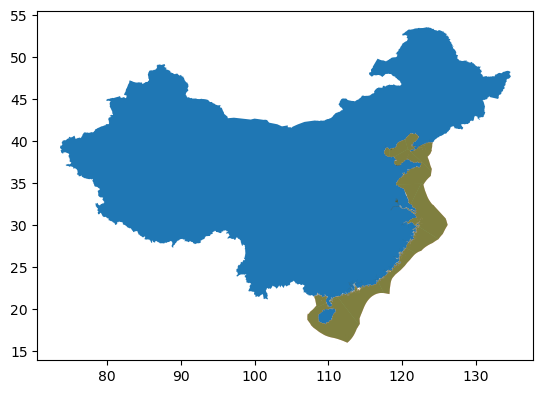

In [12]:
fig, ax = plt.subplots()
china_shape = fetch_natural_earth_shape("admin_0_countries", "ADMIN", "China")
china_shape.plot(ax=ax)
gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/regions_offshore_province.geojson").plot(ax=ax, color="red", alpha=0.5)
gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/regions_offshore.geojson").plot(ax=ax, color="green", alpha=0.5)

<Axes: >

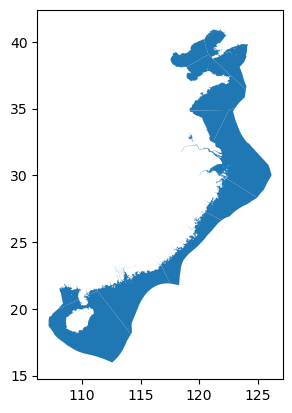

In [13]:
marim=gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/regions_offshore_province.geojson")
marim.plot(lw=3)


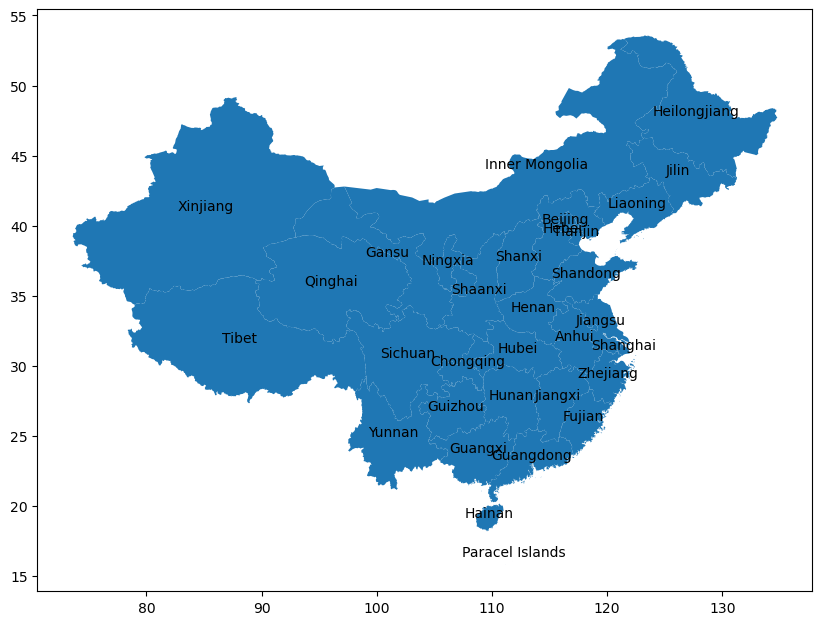

In [14]:
province_shapes = fetch_natural_earth_shape("admin_1_states_provinces", "iso_a2", "CN", region_key = "name_en")
fig, ax = plt.subplots(figsize = (10,10))
province_shapes.plot(ax = ax)

center_point = lambda poly: (poly.centroid.xy[0][0],poly.centroid.xy[1][0])
for idx, row in province_shapes.iterrows():   
    plt.annotate(text=row["region"], xy=center_point(row["geometry"]), horizontalalignment= "center")

[{'MRGID': 8486, 'gazetteerSource': 'Flanders Marine Institute (2023). Maritime Boundaries Geodatabase: Maritime Boundaries and Exclusive Economic Zones (200NM), version 12. Available online at http://www.marineregions.org/. https://doi.org/10.14284/632', 'placeType': 'EEZ', 'latitude': 27.73853, 'longitude': 118.1457, 'minLatitude': 15.97931, 'minLongitude': 107.15944, 'maxLatitude': 41.15916, 'maxLongitude': 126.1863, 'precision': 1624558, 'preferredGazetteerName': 'Chinese Exclusive Economic Zone', 'preferredGazetteerNameLang': 'English', 'status': 'standard', 'accepted': 8486}]
<Filter><PropertyIsEqualTo><PropertyName>mrgid_eez</PropertyName><Literal>8486</Literal></PropertyIsEqualTo></Filter>


<Axes: >

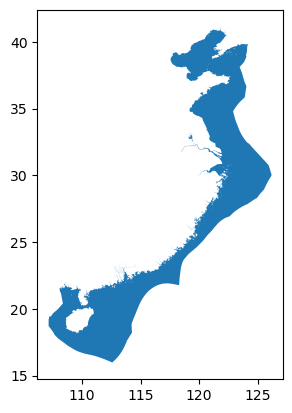

In [15]:
import requests
def fetch_maritime_eez(zone_name:str)->gpd.GeoDataFrame:
    """fetch maritime data for a country from Maritime Gazette API#
    (Royal marine institute of Flanders data base)

    Args:
        zone_name (str): the country's zone name, e.g "Chinese" for china

    Raises:
        requests.HTTPError: if the request fails
    Returns:
        dict: the maritime data
    """    

    def find_record_id(zone_name:str)->int:
        # get Maritime Gazette record ID for the country
        # the eez ID is 70: see https://www.marineregions.org/gazetteer.php?p=webservices&type=rest#/
        url = f'https://www.marineregions.org/rest/getGazetteerRecordsByName.json/{zone_name}/?like=true&fuzzy=false&typeID=70&offset=0&count=100'
        response = requests.get(url)
        if response.status_code != 200:
            raise requests.HTTPError(f"Failed to retrieve Maritime Gazette ID. Status code: {response.status_code}")
        record_data = response.json()
        print(record_data)
        return [data for data in record_data if (data["status"]=="standard") and (data["preferredGazetteerName"].lower().find(zone_name.lower())!=-1)][0]["MRGID"]
    
    mgrid = find_record_id(zone_name)

    #  URL of the WFS service
    url = "https://geo.vliz.be/geoserver/wfs"
    # WFS request parameters + record ID filter
    params = dict(
        service="WFS",
        version="1.1.0",
        request="GetFeature",
        typeName="MarineRegions:eez",
        outputFormat="json",
        filter=f"<Filter><PropertyIsEqualTo><PropertyName>mrgid_eez</PropertyName><Literal>{mgrid}</Literal></PropertyIsEqualTo></Filter>"
    )
    print(f"<Filter><PropertyIsEqualTo><PropertyName>mrgid_eez</PropertyName><Literal>{mgrid}</Literal></PropertyIsEqualTo></Filter>")

    # Fetch data from WFS using requests
    response_eez = requests.get(url, params=params)

    # Check for successful request
    if response_eez.status_code == 200:
        data = response_eez.json()
    else:
        print(f"Error: {response_eez.status_code}")
    if data["totalFeatures"] !=1:
        raise ValueError(f"Expected 1 feature, got {data['totalFeatures']}\n: {data}")
    return gpd.GeoDataFrame.from_features(data["features"]) 
eez = fetch_maritime_eez("chinese")
eez.set_crs(epsg=4326, inplace=True)
eez.plot()

In [34]:
prov_centroids = province_shapes.copy()
prov_centroids.geometry = prov_centroids.centroid

/tmp/ipykernel_353826/1220609652.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prov_centroids.geometry = prov_centroids.centroid


In [45]:
voronoi_cells = gpd.GeoDataFrame(
    geometry=province_shapes.centroid.voronoi_polygons(), crs=province_shapes.crs
)
province_shapes = province_shapes.rename(columns={"region": "province"})
prov_centroids = province_shapes.copy()
prov_centroids.geometry = prov_centroids.centroid
voronoi_cells = voronoi_cells.sjoin(prov_centroids, predicate="contains")#.set_index("province")
# {'intersects', None, 'contains_properly', 'within', 'dwithin', 'touches', 'contains', 'overlaps', 'crosses', 'covered_by', 'covers'}
# check the below with ez.overlay(voronoi_cells, how="intersection").boundary.plot()
voronoi_cells.shape

/tmp/ipykernel_353826/1801584016.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=province_shapes.centroid.voronoi_polygons(), crs=province_shapes.crs
/tmp/ipykernel_353826/1801584016.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prov_centroids.geometry = prov_centroids.centroid


(32, 3)

In [48]:
if "index_right" in voronoi_cells.columns:  
    voronoi_cells.drop(columns=["index_right"], inplace=True)

<Axes: >

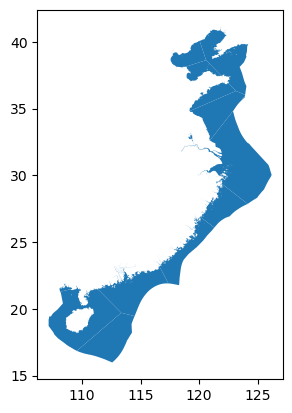

In [56]:
voronoi_cells.overlay(eez, how="intersection")[["province", "geometry"]].set_index("province").plot()

In [37]:
voronoi_cells.shape

(32, 1)

In [57]:
gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/derived_data/regions/provinves_offshore.geojson")

,province,geometry
0,Hainan,"POLYGON ((109.05741 21.4726, 109.05772 21.4711..."
1,Guangxi,"MULTIPOLYGON (((109.66028 21.59791, 109.66296 ..."
2,Guangdong,"MULTIPOLYGON (((116.38923 23.55674, 116.38941 ..."
3,Fujian,"MULTIPOLYGON (((116.61287 23.18293, 116.613 23..."
4,Anhui,"POLYGON ((118.58344 31.92264, 118.58145 31.921..."
5,Shandong,"MULTIPOLYGON (((118.54251 38.05367, 118.52984 ..."
6,Liaoning,"MULTIPOLYGON (((123.15023 36.33009, 122.51746 ..."
7,Tianjin,"POLYGON ((120.04878 40.07671, 120.04959 40.070..."
8,Zhejiang,"MULTIPOLYGON (((120.11021 26.88824, 120.11688 ..."
9,Jiangsu,"MULTIPOLYGON (((123.92844 36.03355, 123.91942 ..."


<Axes: >

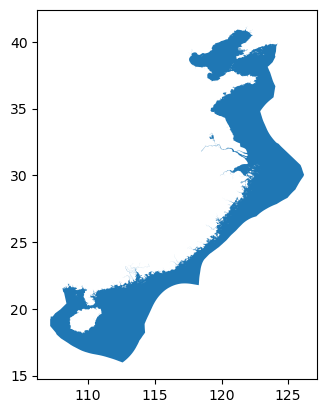

In [ ]:
gpd.GeoDataFrame.from_features(data["features"]).plot()

<Axes: >

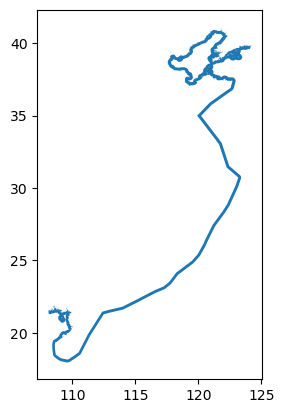

In [ ]:
gpd_eez = gpd.GeoDataFrame([{'geometry': wkt_loads(wkt_s)}])
fig, ax = plt.subplots()
gpd_eez.set_crs(CRS, inplace=  True)
gpd_eez.plot(ax=ax)

<Axes: >

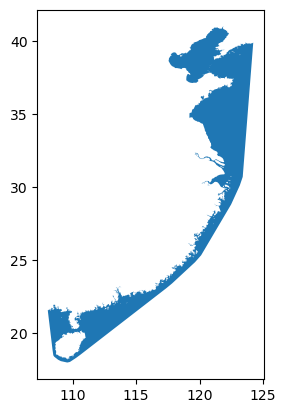

In [ ]:
gpd_eez.convex_hull.difference(china_shape).plot()

In [ ]:
geom.split("MULTIPOLYGON")[-1]

'<http://www.opengis.net/def/crs/OGC/1.3/CRS84> POLYGON ((108.12647449 21.31269079, 108.1176223 21.35254757, 108.11349995 21.37110834, 108.10240914 21.42104448, 108.10032381 21.4304336, 108.09547222 21.45227778, 108.09411111 21.45641667, 108.09441667 21.45783333, 108.09556221 21.45894925, 108.09763889 21.46097222, 108.09936111 21.46391667, 108.0999581 21.46569233, 108.10044444 21.46713889, 108.10119444 21.47013889, 108.10146582 21.48456633, 108.10152654 21.48779426, 108.10159272 21.49131283, 108.10170473 21.4972679, 108.10159087 21.49739711, 108.10147667 21.49752586, 108.10136214 21.49765416, 108.10124727 21.49778201, 108.10113207 21.4979094, 108.10101654 21.49803633, 108.10090068 21.49816281, 108.10078448 21.49828883, 108.10066795 21.49841439, 108.10055109 21.4985395, 108.1004339 21.49866416, 108.10031637 21.49878836, 108.10019851 21.4989121, 108.09878471 21.50038684, 108.09798569 21.50138158, 108.09625907 21.50353115, 108.09615302 21.50366411, 108.09604742 21.50379741, 108.09594228 2

<Axes: >

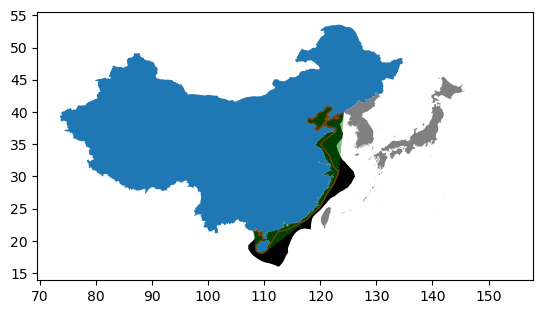

In [ ]:
from shapely.wkt import loads as wkt_loads

# sanitize the WKT string
wkt_s = "POLYGON" + geom.split("POLYGON")[-1].split('"')[0]
fig, ax = plt.subplots()
gpd.read_file("/home/ivanra/documents/PyPSA-China-PIK/resources/data/regions/regions_offshore.geojson").plot(ax=ax, color="black")
eez = gpd.GeoDataFrame([{'geometry': wkt_loads(wkt_s)}])
eez.plot(ax=ax, color="red")
fetch_natural_earth_shape("admin_0_countries", "ADMIN", "China").plot(ax=ax)
fetch_natural_earth_shape("admin_0_countries", "ADMIN", "Taiwan").plot(ax=ax, color = "grey")
fetch_natural_earth_shape("admin_0_countries", "ADMIN", "North Korea").plot(ax=ax, color = "grey")
fetch_natural_earth_shape("admin_0_countries", "ADMIN", "South Korea").plot(ax=ax, color = "grey")
fetch_natural_earth_shape("admin_0_countries", "ADMIN", "Japan").plot(ax=ax, color = "grey")
gpd_eez.convex_hull.difference(china_shape).plot(ax = ax, color="green", alpha = 0.5)